In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
import gc
import torch
import torch.nn as nn
from transformer_lens import HookedTransformer
from transformer_lens import utils as tl_utils
from transformers import AutoModelForCausalLM, AutoTokenizer
import einops
from jaxtyping import Int, Float
from torch import Tensor
from matplotlib import pyplot as plt
import numpy as np
import functools
from typing import Dict, Optional, Tuple, Union
from jaxtyping import Float, Int
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.hook_points import HookedRootModule, HookPoint
from copy import deepcopy

In [3]:
device_ids = [0, 1]
devices = [torch.device(f"cuda:{i}") for i in device_ids]

In [5]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

hf_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float32,
).to(devices[0])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tl_model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    hf_model=AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float32,
    ),
    tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME),
    device=devices[1],
    n_devices=1,
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    torch_dtype=torch.float32,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [4]:
def check_similarity_with_hf_model(
    tl_model: HookedTransformer,
    hf_model: AutoModelForCausalLM,
    atol: float,
    prompt="Hello world!",
):
    tokens = tl_model.tokenizer.encode(prompt, return_tensors="pt")
    hf_logits = hf_model(tokens.to(devices[0])).logits
    tl_logits = tl_model(tokens.to(devices[1]), prepend_bos=False)
    assert torch.allclose(tl_logits.cpu(), hf_logits.cpu(), atol=atol), f"Numerical error with atol={atol}"

In [7]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1)

AssertionError: Numerical error with atol=1

The epsilon value used in the Llama2 RMSNorm huggingface is 1e-5, even though the default argument value for the class is 1e-6 [(see here)](https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L96).

In [11]:
print(f"HF model eps value for input LN is {hf_model.model.layers[0].input_layernorm.variance_epsilon}")
print(f"HF model eps value for post-attention LN is {hf_model.model.layers[0].post_attention_layernorm.variance_epsilon}")

HF model eps value for input LN is 1e-05
HF model eps value for post-attention LN is 1e-05


We'll now modify the `eps` parameter to also be `1e-5` in the layer norm modules of our Llama-7B transformer_lens model. It's set to `1e-6` by default.

In [12]:
print(f"TL model eps value for input LN is {tl_model.blocks[0].ln1.eps}")
print(f"TL model eps value for post-attention LN is {tl_model.blocks[0].ln2.eps}")

TL model eps value for input LN is 1e-06
TL model eps value for post-attention LN is 1e-06


In [69]:
tl_model.ln_final.eps = 1e-5
for layer in range(32):
    tl_model.blocks[layer].ln1.eps = 1e-5
    tl_model.blocks[layer].ln2.eps = 1e-5

The previous similarity test doesn't fail anymore:

In [23]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1)

It passes with `atol=1e-4`:

In [24]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1e-4)

It no longer passes with `atol=1e-5`:

In [25]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1e-5)

AssertionError: Numerical error with atol=1e-05

We can also compare the relative error of the residual stream at intermediate layers

In [33]:
class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.save_activations = False 
        self.activations = None

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        return output

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.block.self_attn = AttnWrapper(self.block.self_attn)

        self.activations = None

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        activations: Float[Tensor, "batch_size seq_len d_model"] = output[0]
        self.activations = activations
        return output

    def reset(self):
        self.activations = None
        self.block.self_attn.activations = None

class Llama2Wrapper:
    def __init__(self, hf_model):
        self.wrapped_model = hf_model

        for i, layer in enumerate(self.wrapped_model.model.layers):
            self.wrapped_model.model.layers[i] = BlockOutputWrapper(
                layer, self.wrapped_model.lm_head, self.wrapped_model.model.norm
            )

    def get_last_activations(self, layer):
        return self.wrapped_model.model.layers[layer].activations

    def reset_all(self):
        for layer in self.wrapped_model.model.layers:
            layer.reset()

    def unwrap(self):
        for i, layer in enumerate(self.wrapped_model.model.layers):
            self.wrapped_model.model.layers[i] = layer.block

    def __call__(self, *args, **kwargs):
        return self.wrapped_model(*args, **kwargs)

# make sure to unwrap the model before initializing it again
# hf_wrapped_model.unwrap()
hf_wrapped_model = Llama2Wrapper(hf_model)

In [68]:
def check_relative_error_layer_resid_post(layer):
    hf_wrapped_model.reset_all()

    tokens = tl_model.tokenizer.encode("Hello world!", return_tensors="pt").cpu()

    hf_activations = torch.zeros((len(tokens), len(tokens[0]), 4096), device="cpu", dtype=torch.float32)
    tl_activations = torch.zeros_like(hf_activations, device="cpu", dtype=torch.float32)

    with torch.no_grad():
        hf_wrapped_model(tokens.to(devices[0]))
        hf_activations = hf_wrapped_model.get_last_activations(layer).cpu()
        print("HF activations", hf_activations[0, 0, :5])

    def store_activations(activations, hook, tl_activations_):
        tl_activations_ += activations.cpu()
        print("TL activations", tl_activations_[0, 0, :5])
    
    hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_resid_post")
    hook_fn = functools.partial(store_activations, tl_activations_=tl_activations)
    
    with torch.no_grad():
        tl_model.run_with_hooks(
            tokens.to(devices[1]),
            prepend_bos=False,
            fwd_hooks=[(hook_filter, hook_fn)],
        )

    diff = torch.abs((hf_activations - tl_activations) / (torch.abs(hf_activations) + 1e-5))
    print("Errors", diff[0, 0, :5])

    mean_diff = diff.mean().item()
    std_diff = diff.std().item()
    max_diff = diff.max().item()

    print(f"Layer {layer}, mean relative error: {mean_diff:.3f}, std diff: {std_diff:.3f}, max error: {max_diff:.3f}")
    print("")

    hf_wrapped_model.reset_all()

    return mean_diff, std_diff, max_diff

We'll calculate and plot the average relative error across the different layers.

In [70]:
mean_diffs, std_diffs, max_diffs = [], [], []

for layer in range(32):
    mean_diff, std_diff, max_diff = check_relative_error_layer_resid_post(layer)
    mean_diffs.append(mean_diff)
    std_diffs.append(std_diff)
    max_diffs.append(max_diff)


HF activations tensor([-0.0116,  0.0113,  0.0560,  0.0331, -0.1477])
TL activations tensor([-0.0116,  0.0113,  0.0560,  0.0331, -0.1477])
Errors tensor([3.2033e-06, 3.2998e-06, 4.6581e-07, 1.5755e-06, 2.0176e-07])
Layer 0, mean relative error: 0.000, std diff: 0.000, max error: 0.001

HF activations tensor([ 0.0699, -0.5114,  0.0642, -0.0617, -0.0583])
TL activations tensor([ 0.0699, -0.5114,  0.0642, -0.0617, -0.0583])
Errors tensor([4.2650e-07, 2.3310e-07, 3.4816e-07, 9.0548e-07, 8.9425e-07])
Layer 1, mean relative error: 0.000, std diff: 0.000, max error: 0.002

HF activations tensor([ 0.1070, -0.5451,  0.0946, -0.1130, -0.0241])
TL activations tensor([ 0.1070, -0.5451,  0.0946, -0.1130, -0.0241])
Errors tensor([4.1771e-07, 2.1870e-07, 4.7273e-07, 9.2263e-07, 2.8562e-06])
Layer 2, mean relative error: 0.000, std diff: 0.000, max error: 0.002

HF activations tensor([ 0.1178, -0.5735,  0.1002, -0.1144, -0.0045])
TL activations tensor([ 0.1178, -0.5735,  0.1002, -0.1144, -0.0045])
Erro

**Notice that the y-axis of the next plot is scaled by `1e-6`**

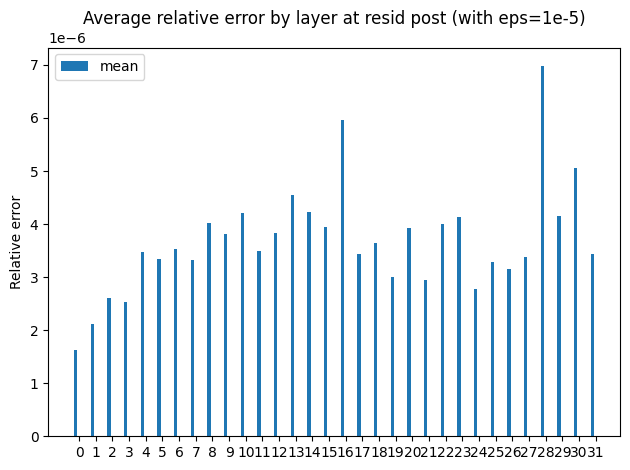

In [71]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_diffs, width, label='mean')

ax.set_ylabel('Relative error')
ax.set_title('Average relative error by layer at resid post (with eps=1e-5)')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

We'll plot the maximum relative error across the 4096 elements in the residual vector.

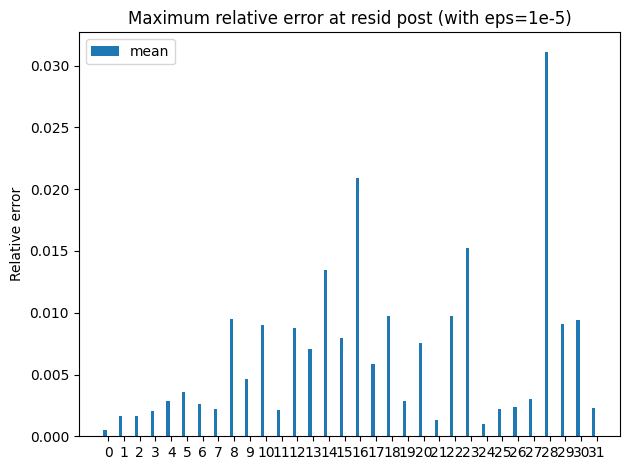

In [72]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, max_diffs, width, label='mean')

ax.set_ylabel('Relative error')
ax.set_title('Maximum relative error at resid post (with eps=1e-5)')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

Let's reset the epsilon parameter back to the original one (that caused the numerical inconsistencies with the HF models) and plot the same metrics.

In [73]:
tl_model.ln_final.eps = 1e-6
for layer in range(32):
    tl_model.blocks[layer].ln1.eps = 1e-6
    tl_model.blocks[layer].ln2.eps = 1e-6

In [74]:
mean_diffs, std_diffs, max_diffs = [], [], []

for layer in range(32):
    mean_diff, std_diff, max_diff = check_relative_error_layer_resid_post(layer)
    mean_diffs.append(mean_diff)
    std_diffs.append(std_diff)
    max_diffs.append(max_diff)


HF activations tensor([-0.0116,  0.0113,  0.0560,  0.0331, -0.1477])
TL activations tensor([-0.0130,  0.0088,  0.0571,  0.0356, -0.1513])
Errors tensor([0.1196, 0.2239, 0.0201, 0.0765, 0.0241])
Layer 0, mean relative error: 0.313, std diff: 2.185, max error: 129.648

HF activations tensor([ 0.0699, -0.5114,  0.0642, -0.0617, -0.0583])
TL activations tensor([ 0.0669, -0.5043,  0.0658, -0.0571, -0.0646])
Errors tensor([0.0419, 0.0139, 0.0249, 0.0749, 0.1078])
Layer 1, mean relative error: 0.346, std diff: 4.389, max error: 357.976

HF activations tensor([ 0.1070, -0.5451,  0.0946, -0.1130, -0.0241])
TL activations tensor([ 0.1041, -0.5380,  0.0961, -0.1084, -0.0304])
Errors tensor([0.0274, 0.0131, 0.0168, 0.0414, 0.2622])
Layer 2, mean relative error: 0.378, std diff: 3.963, max error: 209.039

HF activations tensor([ 0.1178, -0.5735,  0.1002, -0.1144, -0.0045])
TL activations tensor([ 0.1149, -0.5665,  0.1016, -0.1097, -0.0108])
Errors tensor([0.0242, 0.0123, 0.0143, 0.0410, 1.3917])
La

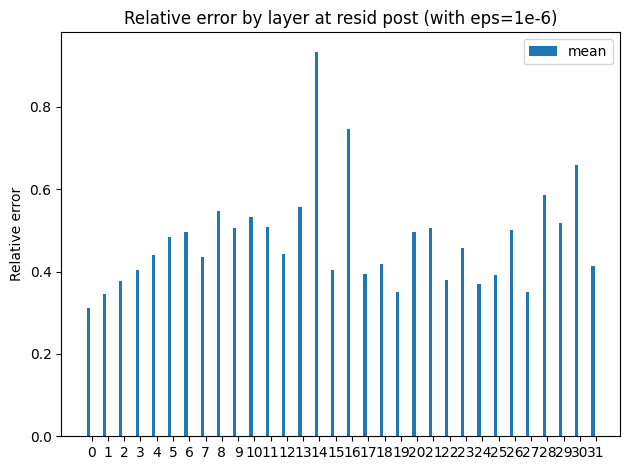

In [75]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_diffs, width, label='mean')

ax.set_ylabel('Relative error')
ax.set_title('Relative error by layer at resid post (with eps=1e-6)')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

The y-axis isn't scaled in this plot. The errors are surprisingly extremely big, especially at layer 14. I feel that they can't be that large and I must have made some implementation mistake but I can't find any (yet).

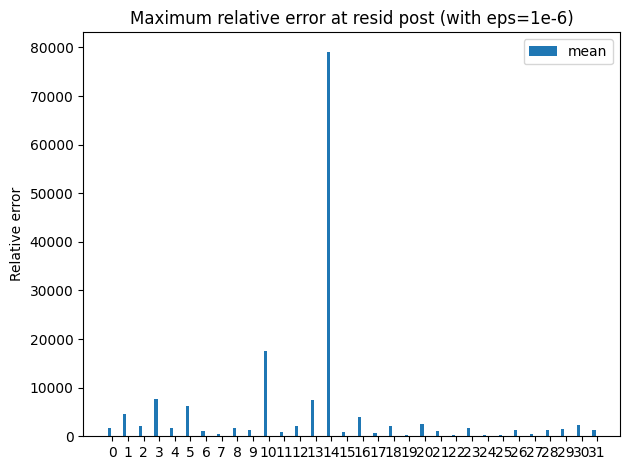

In [66]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, max_diffs, width, label='mean')

ax.set_ylabel('Relative error')
ax.set_title('Maximum relative error at resid post (with eps=1e-6)')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

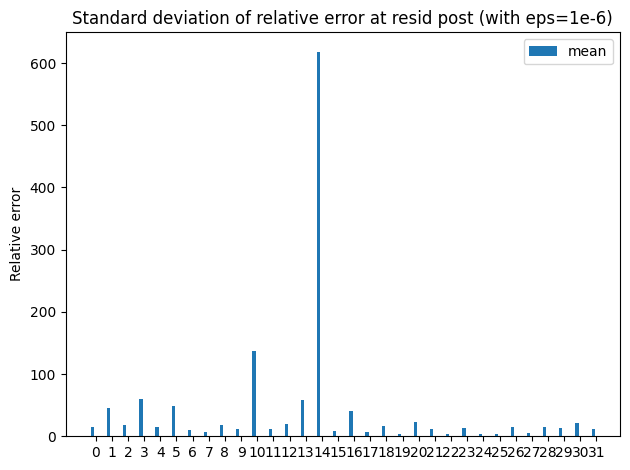

In [67]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, std_diffs, width, label='mean')

ax.set_ylabel('Relative error')
ax.set_title('Standard deviation of relative error at resid post (with eps=1e-6)')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()